In [ ]:
# imports
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV, ElasticNetCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import optuna


Importing the data and pre-processing

In [21]:
df = pd.read_csv("./data/UROMOL_TaLG.teachingcohort.csv")
first_column = df.columns[0]
df = df.drop([first_column], axis=1)

# drop columns without target featurre
df = df.dropna(subset=["Recurrence", "RFS_time"])

# Define target variable based on recurrence status
df["risk_group"] = "No Recurrence"
df.loc[df["Recurrence"] == 1, "risk_group"] = pd.qcut(
    df.loc[df["Recurrence"] == 1, "RFS_time"], 
    q=[0, 0.5, 1], 
    labels=["Low", "High"]
)

/var/folders/vx/fpmf15096617bm5hj9zlgpn80000gn/T/ipykernel_6730/2196157171.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/UROMOL_TaLG.teachingcohort.csv")


In [22]:
# removing all columns with only one value
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_cols)

In [23]:
# Drop unnecessary columns (e.g., patient IDs)
df = df.drop(columns=["UROMOL.ID", "Progression", "PFS_time."], errors="ignore")

# Separate features and target
y = df["risk_group"] 
X = df.drop(columns=["risk_group", "RFS_time", "Recurrence"])  # Features # Target

In [24]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown="ignore")
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))

X_encoded = pd.DataFrame(
    encoder.fit_transform(X[categorical_cols]).toarray(),  
    columns=encoder.get_feature_names_out(categorical_cols)  
)
X_encoded.index = X.index

X_encoded = X_encoded.rename(columns={
    'Tumor.size_< 3 cm': 'Tumor.size_less_three',
    'Tumor.size_>= 3 cm': 'Tumor.size_more_three'
})

# Combine encoded categorical and numerical features
X_processed = pd.concat([X_encoded, df[numerical_cols]], axis=1)

In [25]:
# KNN Imputation for missing values
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_processed)
X_processed_imputed = pd.DataFrame(X_imputed, columns=X_processed.columns)

Checking for missing values after imputation

In [26]:
na_count = X_processed_imputed.isna().any(axis=1).sum()
print(na_count)

0


In [27]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_processed_imputed, y_encoded, test_size=0.2, random_state=42, stratify=y)

## Lasso Regression

In [ ]:
# for optuna
def objective(trial):
    eps = trial.suggest_loguniform("eps", 1e-4, 1.0)
    model = LassoCV(eps=eps, random_state=43)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# get best eps
best_eps = study.best_params['eps']

# train lasso with best eps
lasso = LassoCV(alpha=best_eps, random_state=43)
lasso.fit(X_train, y_train)

# predictions
y_pred_lasso = lasso.predict(X_test)
y_pred_lasso_proba = lasso.predict_proba(X_test)

## Elastic Net

In [ ]:
def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0)

    elastic_net = ElasticNetCV(alpha=alpha, l1_ratio=l1_ratio, random_state=43)
    score = cross_val_score(elastic_net, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params

elastic_net = ElasticNetCV(alpha=best_params["alpha"], l1_ratio=best_params["l1_ratio"], random_state=43)
elastic_net.fit(X_train, y_train)

y_pred_en = elastic_net.predict(X_test)
y_pred_en_proba = elastic_net.predict_proba(X_test)

## Random Forest

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    random_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=43,
        n_jobs=-1
    )

    score = cross_val_score(random_forest, X_train, y_train, cv=5, scoring="accuracy").mean()
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
random_forest = RandomForestClassifier(**best_params, random_state=43, n_jobs=-1)
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)
y_pred_rf_proba = random_forest.predict_proba(X_test)

## GBM

In [ ]:
def objective_gbm(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.5)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    gbm = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=43
    )

    score = cross_val_score(gbm, X_train, y_train, cv=5, scoring="accuracy").mean()
    return score

study_gbm = optuna.create_study(direction="maximize")
study_gbm.optimize(objective_gbm, n_trials=50)

best_params_gbm = study_gbm.best_params
gbm = GradientBoostingClassifier(**best_params_gbm, random_state=43)
gbm.fit(X_train, y_train)

y_pred_gbm = gbm.predict(X_test)
y_pred_gbm_proba = gbm.predict_proba(X_test)

## XGBoost

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.5)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_loguniform("gamma", 1e-8, 10.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    xgb = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=43
    )

    score = cross_val_score(xgb, X_train, y_train, cv=5, scoring="accuracy").mean()
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params

xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=43)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_proba = xgb.predict_proba(X_test)

## Creating the ensemble

In [ ]:
model_results = {
    "Lasso":         (y_pred_lasso,  y_pred_lasso_proba),
    "ElasticNet":    (y_pred_en,    y_pred_en_proba),
    "RandomForest":  (y_pred_rf,       y_pred_rf_proba),
    "GBM":           (y_pred_gbm,      y_pred_gbm_proba),
    "XGBoost":       (y_pred_xgb,      y_pred_xgb_proba)
}

performance_data = []

for model_name, (preds, scores) in model_results.items():
    # accuracy
    acc = accuracy_score(y_test, preds)

    # AUC 
    auc_val = roc_auc_score(y_test, scores)

    # sensitivity - recall for the positive class
    sens = recall_score(y_test, preds, pos_label=1)

    performance_data.append({
        'Model': model_name,
        'Accuracy': acc,
        'AUC': auc_val,
        'Sensitivity': sens
    })

perf_df = pd.DataFrame(performance_data)
print("=== Model Performance Summary ===")
display(perf_df)


model_names = perf_df['Model'].tolist()

# set up majority vote ensemble among chosen models
def ensemble_vote(models_list, model_results_dict, threshold):
    sum_preds = np.zeros_like(y_test, dtype=int)
    for m in models_list:
        sum_preds += model_results_dict[m][0] 

    return (sum_preds >= threshold).astype(int)

# majority is 3 votes or more.
ensemble_sens_pred = ensemble_vote(model_names, model_results, threshold=3)

# evaluate the ensemble
def evaluate_ensemble(ensemble_name, ensemble_pred, model_names):
    print(f"\n{ensemble_name} Ensemble")
    print("Using models:", model_names)

    # Confusion Matrix
    cm = confusion_matrix(y_test, ensemble_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{ensemble_name} Ensemble Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(classification_report(y_test, ensemble_pred))

    # Approximate Probability for ROC:
    sum_preds = np.zeros_like(y_test, dtype=int)
    for m in model_names:
        sum_preds += model_results[m][0]
    ensemble_score = sum_preds / 5.0

    fpr, tpr, _ = roc_curve(y_test, ensemble_score)
    auc_val = roc_auc_score(y_test, ensemble_score)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{ensemble_name} (AUC={auc_val:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{ensemble_name} Ensemble ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

evaluate_ensemble("Top-5 by Sensitivity", ensemble_sens_pred, best5_sens_names)


In [ ]:
# Define individual models
models = {
    "EN": LogisticRegression(penalty='l2', max_iter=500),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RF": RandomForestClassifier(n_estimators=100),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)

# Ensemble: Voting Classifier (Soft Voting for Confidence Scores)
ensemble = VotingClassifier(estimators=list(models.items()), voting="soft")
ensemble.fit(X_train, y_train)

# Predictions & Confidence Scores
y_pred = ensemble.predict(X_test)
y_prob = ensemble.predict_proba(X_test)  # Confidence values

y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Convert confidence scores to dictionary for better interpretation
confidence_scores = [
    {category: prob for category, prob in zip(ensemble.classes_, probs)}
    for probs in y_prob
]

Confusion Matrix:
 [[11  7  1]
 [ 9  9  1]
 [ 4  3 11]]

Classification Report:
                precision    recall  f1-score   support

         High       0.46      0.58      0.51        19
          Low       0.47      0.47      0.47        19
No Recurrence       0.85      0.61      0.71        18

     accuracy                           0.55        56
    macro avg       0.59      0.55      0.56        56
 weighted avg       0.59      0.55      0.56        56

ROC-AUC Score: 0.7132132132132133


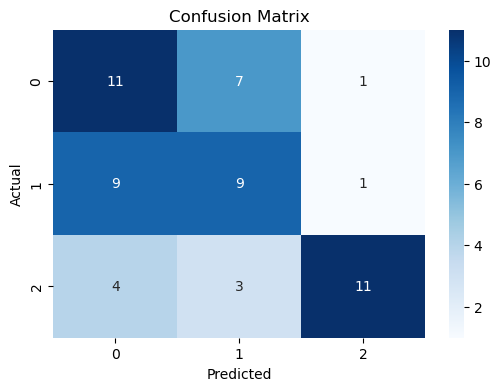

In [19]:
# Evaluate Performance
print("Confusion Matrix:\n", confusion_matrix(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))
print("ROC-AUC Score:", roc_auc_score(pd.get_dummies(y_test_decoded), y_prob, multi_class="ovr"))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_decoded, y_pred_decoded), annot=True, fmt="d", cmap="Blues", xticklabels=ensemble.classes_, yticklabels=ensemble.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group in [1, 2, 0]:
    mask = df["risk_group"] == group
    kmf.fit(df["RFS_time"][mask], event_observed=(df["risk_group"] != 0))
    kmf.plot_survival_function(label=group)

plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [ ]:
# Save Model
with open("ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble, f)

# Example Output: First 5 Predictions with Confidence Scores
for i in range(5):
    print(f"Prediction: {y_pred[i]}, Confidence Scores: {confidence_scores[i]}")